<right><img src="iDSDL-Logo.png" width="200px" align="right"></right>
<br><br><br><br>

<center>
<h1>1. Unsupervised Modelling</h1>
</center>

<br>

<p>
    <center>
<b>Alexander Schindler (AIT/TU Wien)</b><br>
schindler@ifs.tuwien.ac.at / alexander.schindler@ait.ac.at<br>
<a href="http://www.ifs.tuwien.ac.at/%7Eschindler/">http://www.ifs.tuwien.ac.at/~schindler/</a><br>
<a href="https://www.linkedin.com/in/schindleralexander">LinkedIn</a> | <a href="https://twitter.com/Slychief">Twitter</a>
        </center>
</p>
</center>

# Imports

Select GPU if you have multiple devices

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]    = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Import relevant libraries

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os
import glob

import numpy as np
import pandas as pd

import cv2

import progressbar

from IPython.display import Image

Set data paths

In [3]:
DATA_PATH            = "/datastorage_fast/FIDS30_all"
IMAGES_PATH          = "/datastorage_fast/FIDS30_all"
IMAGES_LABELLED_PATH = "/datastorage_fast/FIDS30"

store_dir            = "/datastorage_fast/FIDS30_temp"

# Metadata

Load and create metadata from dataset directory

In [4]:
filenames = []

for path, subdirs, files in os.walk(IMAGES_PATH):
    for name in files:
        if name.find(".jpg") != -1:
            filenames.append(os.path.join(path, name))

metadata_images          = pd.DataFrame(filenames, columns=["Filename"])
metadata_images.head()

Filename
0       /datastorage_fast/FIDS30_all/lemons_37.jpg
1  /datastorage_fast/FIDS30_all/blackberries_7.jpg
2       /datastorage_fast/FIDS30_all/mangos_23.jpg
3        /datastorage_fast/FIDS30_all/guava_32.jpg
4       /datastorage_fast/FIDS30_all/bananas_6.jpg

In [5]:
metadata_images.shape

(971, 1)

# Load Images

## Preprocessing Functions

In [6]:
def resize_image(img, height, width):
    
    is_color              = len(img.shape) == 3
    src_height, src_width = img.shape[:2]
    
    # calc ratio
    ratio = np.min([float(height) / src_height, float(width) / src_width])
    
    new_height = np.round(src_height * ratio).astype(int)
    new_width  = np.round(src_width  * ratio).astype(int)
    
    img_reshaped = cv2.resize(img, (new_width,new_height), interpolation=cv2.INTER_CUBIC)

    if new_height < height:
        
        if is_color:
            dims = (height - new_height, new_width, 3)
        else:
            dims = (height - new_height, new_width)
        
        padding      = np.ones(dims, dtype=np.uint8)
        padding     *= 255
        img_reshaped = np.concatenate([img_reshaped, padding], axis=0)
    
    elif new_width < width:
        
        if is_color:
            dims = (new_height, width - new_width, 3)
        else:
            dims = (new_height, width - new_width)
        
        padding      = np.ones(dims, dtype=np.uint8)
        padding     *= 255

        img_reshaped = np.concatenate([img_reshaped, padding], axis=1)
        
    if not ((img_reshaped.shape[0] == height) & (img_reshaped.shape[1] == width)):
        print(img_reshaped.shape)
        raise Exception("resize error")
    
    return img_reshaped, ratio

## Load Images

In [7]:
pbar = progressbar.ProgressBar(max_value=metadata_images.shape[0])

document_images     = []
image_metadata_idx  = []
failed_idx          = []

for i, f_name in pbar(enumerate(metadata_images.Filename.values)):
    
    try:

        img = cv2.imread(f_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img, _ = resize_image(img, height=128, width=128)
        img = img.astype(np.float32)
        img = img / 255.        
        
        document_images.append(img)
        image_metadata_idx.append(i)
        
    except:
        failed_idx.append(i)

document_images = np.array(document_images)

100% (971 of 971) |######################| Elapsed Time: 0:00:51 Time:  0:00:51


In [8]:
metadata_images.loc[image_metadata_idx, "image_nr"] = np.arange(len(image_metadata_idx))

In [9]:
metadata_images = metadata_images[~metadata_images.image_nr.isna()]

In [10]:
metadata_images.head()

Filename  image_nr
0       /datastorage_fast/FIDS30_all/lemons_37.jpg       0.0
1  /datastorage_fast/FIDS30_all/blackberries_7.jpg       1.0
2       /datastorage_fast/FIDS30_all/mangos_23.jpg       2.0
4       /datastorage_fast/FIDS30_all/bananas_6.jpg       3.0
5     /datastorage_fast/FIDS30_all/tomatoes_21.jpg       4.0

## Pre-Filter images

### Remove blank/white pages

In [11]:
avgs = document_images.mean(axis=3).mean(axis=2).mean(axis=1)
avgs.shape

(963,)

In [12]:
# filter almost white pages
mask = avgs < 0.999

In [13]:
document_images_filtered = document_images[mask]
metadata_images_filtered = metadata_images.loc[mask]

**Copy blank pages to ground truth label 'blank_page'**

In [14]:
# all almost white pages
mask = avgs >= 0.999

In [15]:
#mask

In [16]:
128*128*3

49152

In [17]:
document_images_filtered.shape

(963, 128, 128, 3)

# Model: Auto Encoder

* Deep Convolutional Autoencoder
* Learn latent representation

In [18]:
from keras.models import *
from keras.optimizers import *
from keras.regularizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.constraints import *
from keras.layers import *

Using TensorFlow backend.


## Train Autoencoder

In [68]:
# define inputs
inputs = Input((128, 128, 3))

# normalize inputs
inp = BatchNormalization()(inputs)

# === Encoder ===

activation = 'relu'
filtnr     = 12

encoder = Conv2D(filtnr, 3, activation = activation, padding = 'same')(inp)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
#encoder = Dropout(0.2)(encoder)

encoder = Conv2D(filtnr*2, 3, activation = activation, padding = 'same')(encoder)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
#encoder = Dropout(0.2)(encoder)

encoder = Conv2D(filtnr*4, 3, activation = activation, padding = 'same')(encoder)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
#encoder = Dropout(0.2)(encoder)

encoder = Conv2D(filtnr*8, 3, activation = activation, padding = 'same')(encoder)
encoder = MaxPooling2D(pool_size=(2, 2), padding='same')(encoder)
encoder = BatchNormalization()(encoder)
#encoder = Dropout(0.2)(encoder)

# === Bottleneck ===
bottleneck = Flatten()(encoder)
bottleneck = Dense(256, activation="relu", kernel_constraint=unit_norm())(bottleneck)

# === Decoder ===
decoder = Dense(8*8*8*filtnr, activation="relu")(bottleneck)
decoder = Reshape((8, 8, filtnr*8))(decoder)

decoder = Conv2DTranspose(filtnr*8, 3, activation = activation, padding = 'same')(decoder)
decoder = UpSampling2D((2, 2), interpolation='bilinear')(decoder)

decoder = Conv2DTranspose(filtnr*4, 3, activation = activation, padding = 'same')(decoder)
decoder = UpSampling2D((2, 2), interpolation='bilinear')(decoder)

decoder = Conv2DTranspose(filtnr*2, 3, activation = activation, padding = 'same')(decoder)
decoder = UpSampling2D((2, 2), interpolation='bilinear')(decoder)

decoder = Conv2DTranspose(filtnr, 3, activation = activation, padding = 'same')(decoder)
decoder = UpSampling2D((2, 2), interpolation='bilinear')(decoder)

output = Conv2DTranspose(3, 3, activation = 'sigmoid', padding = 'same')(decoder)

model         = Model(input = inputs, output = output)
model_encoder = Model(input = inputs, output = bottleneck)

model.compile(optimizer = Adam(0.001), loss = 'binary_crossentropy', metrics = ['mse'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 12)      336       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 12)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 64, 64, 12)        48        
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 24)        2616      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 24)        0         
__________

/home/schindler/anaconda/python2/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:54: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
/home/schindler/anaconda/python2/envs/py36/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [20]:
model_encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 12)      336       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 12)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 12)        48        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 24)        2616      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 24)        0         
__________

In [52]:
model.fit(document_images, 
          document_images, 
          batch_size = 64,
          epochs     = 50,
          validation_split = 0.1,
          verbose    = 1)

Train on 866 samples, validate on 97 samples
Epoch 1/50
866/866 [==============================] - 4s 5ms/step - loss: 0.5419 - mean_squared_error: 0.0959 - val_loss: 0.4442 - val_mean_squared_error: 0.0598
Epoch 2/50
866/866 [==============================] - 1s 1ms/step - loss: 0.4218 - mean_squared_error: 0.0527 - val_loss: 0.4070 - val_mean_squared_error: 0.0473
Epoch 3/50
866/866 [==============================] - 1s 1ms/step - loss: 0.4009 - mean_squared_error: 0.0456 - val_loss: 0.3959 - val_mean_squared_error: 0.0430
Epoch 4/50
866/866 [==============================] - 1s 1ms/step - loss: 0.3867 - mean_squared_error: 0.0406 - val_loss: 0.3859 - val_mean_squared_error: 0.0398
Epoch 5/50
866/866 [==============================] - 1s 1ms/step - loss: 0.3793 - mean_squared_error: 0.0379 - val_loss: 0.3847 - val_mean_squared_error: 0.0389
Epoch 6/50
866/866 [==============================] - 1s 1ms/step - loss: 0.3714 - mean_squared_error: 0.0348 - val_loss: 0.3769 - val_mean_squar

### Reconstruction quality example

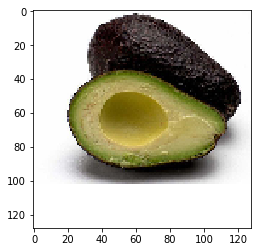

In [53]:
j = 201
i = document_images[j:j+1]

plt.imshow(i[0,:,:,:]);

Image reconstructed by Decoder

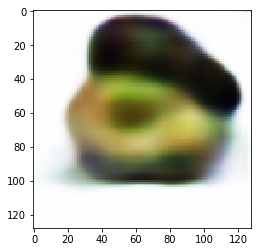

In [54]:
t = model.predict(i)
plt.imshow(t[0,:,:,:]);

In [55]:
model_encoder.predict(i)

array([[ 0.        ,  0.        ,  0.        , 11.365823  ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 12.2493515 ,
         0.        ,  0.        ,  2.5401914 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  7.3946486 ,  7.988348  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.6113396 , 12.981832  ,  0.        ,  0.        ,  0.        ,
        11.671095  ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  5.208673  ,  0.        , 12.506755  ,
         0.        ,  0.        , 26.035982  ,  0.        ,  0.        ,
         0.        ,  9.390147  ,  0.        ,  0.        ,  0.        ,
         0.        , 24.714848  ,  0.        ,  8.927081  ,  0.        ,
         0.        ,  0.        ,  0.        ,  2.1471426 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0. 

## Embedd Image Collection

In [26]:
embeddings = model_encoder.predict(document_images, verbose = 1)

963/963 [==============================] - 0s 450us/step


In [27]:
embeddings.shape

(963, 256)

# Cluster

In [28]:
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering, Birch, SpectralBiclustering
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

## How many clusters to expect?

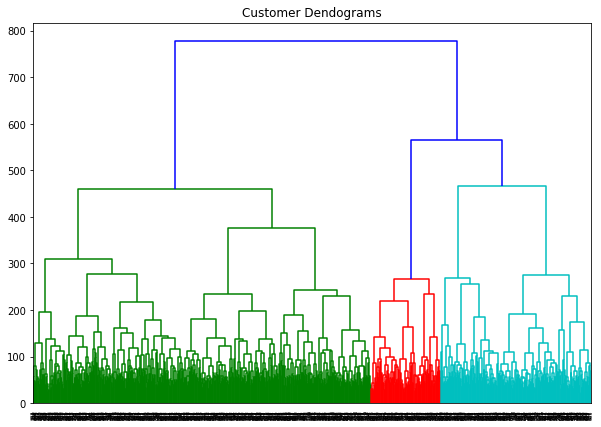

In [29]:
import scipy.cluster.hierarchy as shc

plt.figure(figsize=(10, 7))  
plt.title("Customer Dendograms")  
dend = shc.dendrogram(shc.linkage(embeddings, method='ward'))  

In [30]:
knn_graph = kneighbors_graph(embeddings, 20, include_self=False, metric="cosine")

/home/schindler/anaconda/python2/envs/py36/lib/python3.7/site-packages/sklearn/neighbors/base.py:452: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  result = np.vstack(result)


In [31]:
cc = 20

cl_agglo = AgglomerativeClustering(cc, linkage="ward", connectivity=knn_graph)
cl_agglo.fit(embeddings)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<963x963 sparse matrix of type '<class 'numpy.float64'>'
	with 19260 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=20,
            pooling_func='deprecated')

## Visualization

**PCA projection**

In [32]:
pca = PCA(n_components=2)
x   = pca.fit_transform(embeddings)

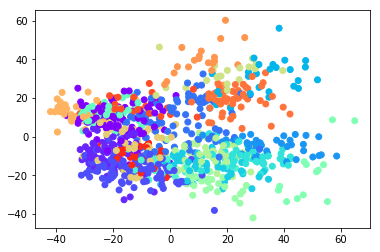

In [33]:
colors = cm.rainbow(np.linspace(0, 1, cc+1))
c      = [colors[i ] for i in cl_agglo.labels_]

plt.scatter(x[:,0], x[:,1], color=c);

**t-distributed Stochastic Neighbor Embedding (T-SNE)**

* converts similarities between data points to joint probabilities
* tries to minimize the Kullback-Leibler divergence between the joint probabilities

In [34]:
from sklearn.manifold import TSNE

In [35]:
X_embedded = TSNE(n_components=2).fit_transform(embeddings)

In [36]:
colors = cm.rainbow(np.linspace(0, 1, cc+1))
c      = [colors[i ] for i in cl_agglo.labels_]

plt.scatter(X_embedded[:,0], X_embedded[:,1], color=c);

**Example Images for Clujsters**

In [37]:
fig     = plt.figure(figsize=(38, 88))
columns = 5
rows    = cl_agglo.labels_.max()

j = 1
for c_idx in range(rows):

    # get cluster center
    center     = embeddings[cl_agglo.labels_ == c_idx].mean(axis=0)
    # get nearest neighbors of center
    sims       = cosine_similarity(center.reshape((1,-1)), embeddings)[0]
    sorted_idx = np.argsort(sims)[::-1]
    
    # display significant images for cluster
    for i in sorted_idx[:columns]:
        fig.add_subplot(rows, columns, j)
        plt.imshow(document_images[i])
        j += 1
        
plt.show()

## DBScan - Find most dense / similar documents

In [38]:
from scipy.spatial.distance import cdist

In [39]:
dists = cdist(embeddings,embeddings, metric="cosine")

In [40]:
dists.mean()

0.7035249551460493

In [41]:
pct = np.percentile(dists, 0.5)
pct

0.23835839250555574

In [42]:
pct = 0.23

In [43]:
cl_db = DBSCAN(n_jobs=10,eps=pct, min_samples=10, algorithm="auto", metric="cosine")
cl_db.fit(embeddings)
np.unique(cl_db.labels_)

array([-1,  0,  1,  2,  3])

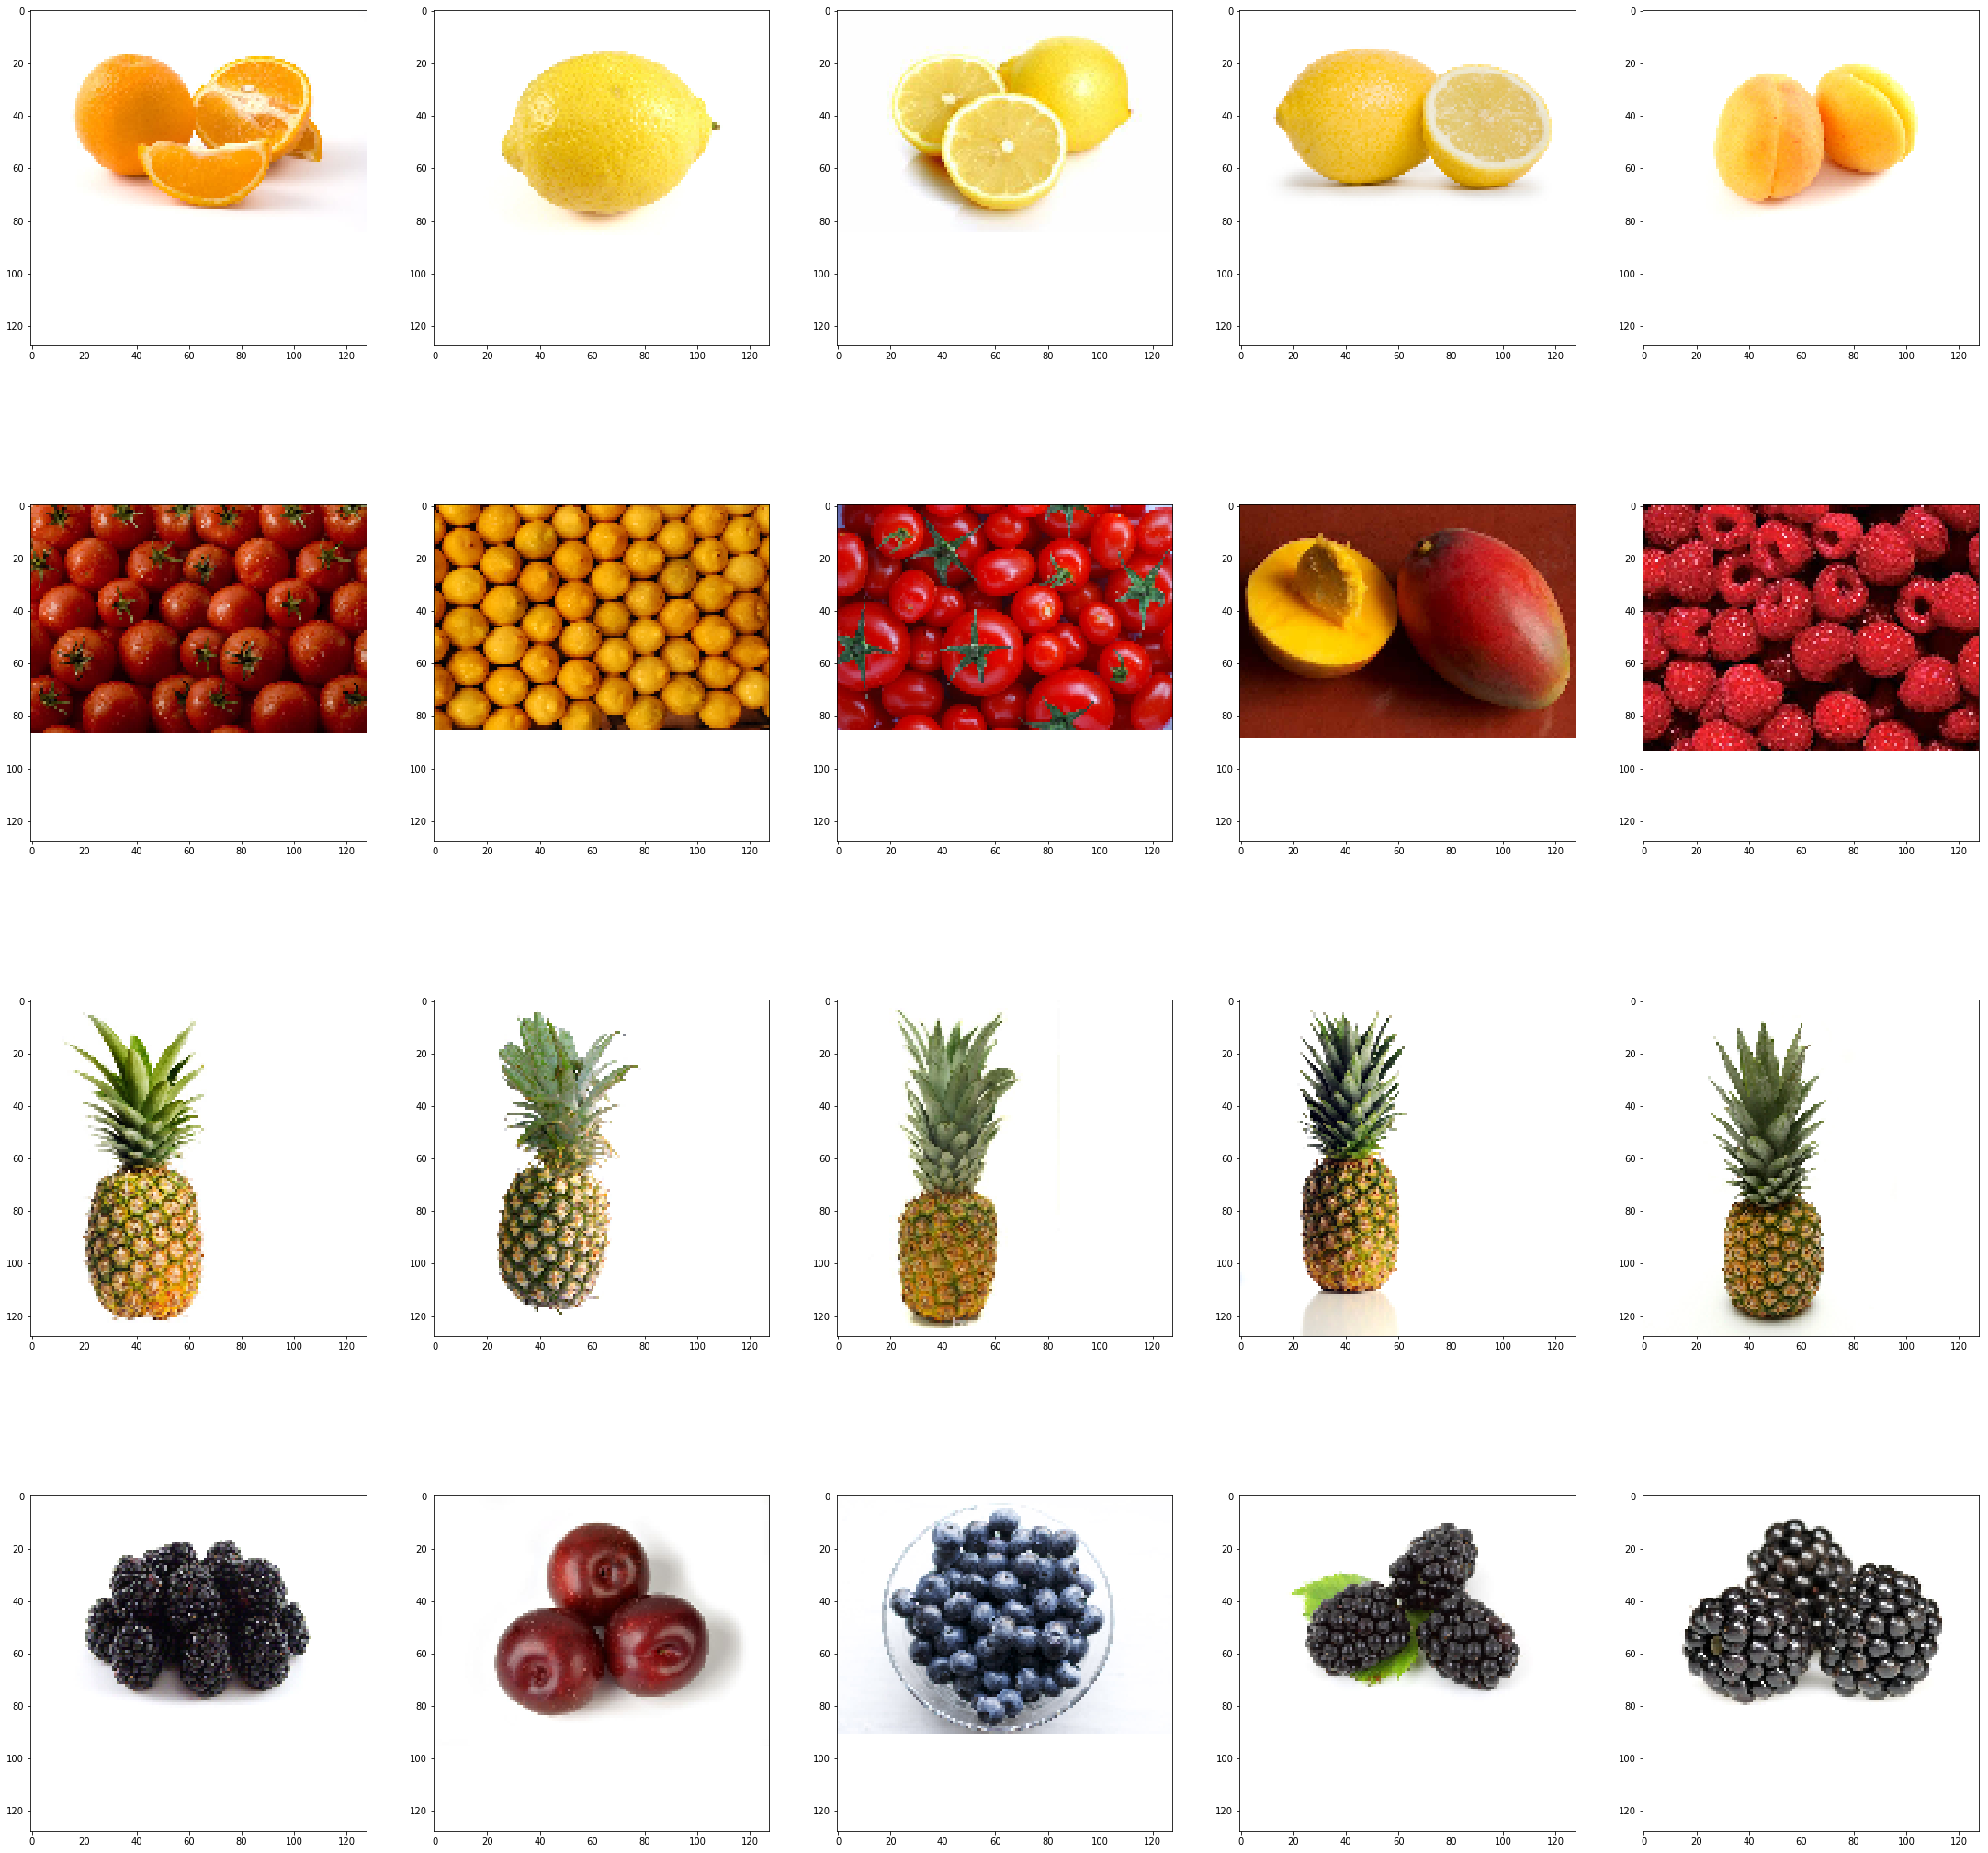

In [44]:
fig=plt.figure(figsize=(38, 38))
columns = 5
rows = cl_db.labels_.max() + 1

j = 1
for c_idx in range(rows):

    center = embeddings[cl_db.labels_ == c_idx].mean(axis=0) 
    sims = cosine_similarity(center.reshape((1,-1)), embeddings)[0]
    sorted_idx = np.argsort(sims)[::-1]
    
    for i in sorted_idx[:columns]:
        fig.add_subplot(rows, columns, j)
        plt.imshow(document_images[i])
        j += 1
plt.show()

# Data Augmentation

In [69]:
from keras.preprocessing.image import ImageDataGenerator

In [70]:
datagen_train = ImageDataGenerator(featurewise_center=False, 
                                   samplewise_center=False, 
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False, 
                                   zca_whitening=False, 
                                   zca_epsilon=1e-06, 
                                   rotation_range=90, 
                                   width_shift_range=10.0, 
                                   height_shift_range=10.0, 
                                   brightness_range=None, 
                                   shear_range=0.0, 
                                   zoom_range=10.0, 
                                   channel_shift_range=0., 
                                   fill_mode='constant', 
                                   cval=1.0, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   rescale=None, 
                                   preprocessing_function=None, 
                                   data_format=None, 
                                   validation_split=0.0, 
                                   dtype=None)

In [71]:
datagen_val = ImageDataGenerator(featurewise_center=False, 
                                 samplewise_center=False, 
                                 featurewise_std_normalization=False, 
                                 samplewise_std_normalization=False, 
                                 zca_whitening=False, 
                                 zca_epsilon=1e-06, 
                                 rotation_range=0, 
                                 width_shift_range=0.0, 
                                 height_shift_range=0.0, 
                                 brightness_range=None, 
                                 shear_range=0.0, 
                                 zoom_range=0.0, 
                                 channel_shift_range=0.0, 
                                 fill_mode='constant', 
                                 cval=1.0, 
                                 horizontal_flip=False, 
                                 vertical_flip=False, 
                                 rescale=None, 
                                 preprocessing_function=None, 
                                 data_format=None, 
                                 validation_split=0.0, 
                                 dtype=None)

## Prepare Evaluation

In [72]:
from sklearn.model_selection import ShuffleSplit

In [73]:
ss = ShuffleSplit(n_splits=1, test_size=0.05)

splits = ss.split(document_images)
train_ids, val_ids = list(splits)[0]

In [74]:
datagen_train.fit(document_images[train_ids])
datagen_val.fit(document_images[val_ids])

In [ ]:
epochs = 50

# here's a more "manual" example
for e in range(epochs):
    
    batches = 0
    for x_batch in datagen_train.flow(document_images[train_ids], None, batch_size=32):
        
        model.train_on_batch(x_batch, x_batch)
        batches += 1
        
        if batches >= train_ids.shape[0] / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    val_loss, val_metrics = model.evaluate(document_images[val_ids], document_images[val_ids], verbose=0)
    print("Epoch %d: val_loss: %.4f - val_mean_squared_error: %.4f" % (e, val_loss, val_metrics))

Epoch 0: val_loss: 0.5308 - val_mean_squared_error: 0.0915
Epoch 1: val_loss: 0.4846 - val_mean_squared_error: 0.0806
Epoch 2: val_loss: 0.4502 - val_mean_squared_error: 0.0694
Epoch 3: val_loss: 0.4441 - val_mean_squared_error: 0.0686
Epoch 4: val_loss: 0.4439 - val_mean_squared_error: 0.0674
Epoch 5: val_loss: 0.4207 - val_mean_squared_error: 0.0603
Epoch 6: val_loss: 0.4221 - val_mean_squared_error: 0.0598
Epoch 7: val_loss: 0.4146 - val_mean_squared_error: 0.0590
Epoch 8: val_loss: 0.4145 - val_mean_squared_error: 0.0574
Epoch 9: val_loss: 0.4170 - val_mean_squared_error: 0.0589
Epoch 10: val_loss: 0.3997 - val_mean_squared_error: 0.0532
Epoch 11: val_loss: 0.3815 - val_mean_squared_error: 0.0453
Epoch 12: val_loss: 0.4093 - val_mean_squared_error: 0.0558
Epoch 13: val_loss: 0.3925 - val_mean_squared_error: 0.0509
Epoch 14: val_loss: 0.3877 - val_mean_squared_error: 0.0490
Epoch 15: val_loss: 0.3820 - val_mean_squared_error: 0.0470
Epoch 16: val_loss: 0.3778 - val_mean_squared_erro

### Reconstruction quality example

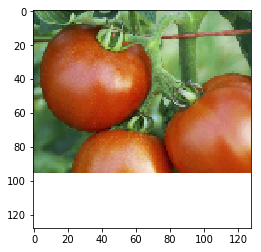

In [66]:
j = 202
i = document_images[j:j+1]

plt.imshow(i[0,:,:,:]);

Image reconstructed by decoder

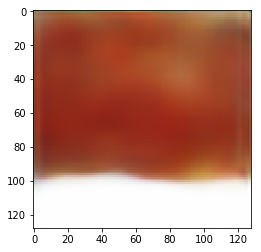

In [67]:
t = model.predict(i)
plt.imshow(t[0,:,:,:]);